## Awesome Italia Remote
Some very kind and skilled Italian guys are behind a website to list companies that hire Italian workers remotely. Their super useful research work can be consulted freely and conveniently at [italiaremote.com](https://italiaremote.com/en/companies), but being a lovely bunch other than kind and skilled they also shared the data in a publicly available [github repository](https://github.com/italiaremote/awesome-italia-remote).  

Let's play a bit with this dataset!

In [5]:
%%bash
# download the data and delete everything else
rm -rf ./data
git clone --depth=1 https://github.com/italiaremote/awesome-italia-remote.git
mv awesome-italia-remote/data ./data
rm -rf awesome-italia-remote

Cloning into 'awesome-italia-remote'...


In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.xkcd(scale=0.5)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['xkcd Script', 'xkcd']

## Loading the data

In [3]:
data_dir = "./data"
json_files = os.listdir(path=data_dir)

In [4]:
companies_list = []
for jf in json_files:
    with open(os.path.join(data_dir, jf)) as jfp:
        companies_list.append(json.load(jfp))

In [5]:
companies_df = pd.DataFrame(companies_list)

## What does the data look like?

**What do we know about each company?**

In [6]:
companies_df.head(3)

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
0,TheFork,https://www.thefork.com/,https://careers.thefork.com/global/en,Product,[cloud_software],Hybrid,[Direct],"[Node.js, React, TypeScript, GraphQL, Kotlin, ..."
1,20tab,https://www.20tab.com/,https://www.20tab.com/connect/careers,Consulting,[cloud_software],Full,[Direct],"[AWS, DevOps, Docker, Django, Firebase, Flutte..."
2,Mollie,https://www.mollie.com/,https://jobs.mollie.com/,Product,[cloud_software],Optional,[Direct],"[PHP, Java, GCP, Data Analysis, Data Science]"


**How is that knowledge stored?**

In [7]:
types_df = pd.DataFrame({
    "columns": companies_df.columns, # column names are easy
    # get the type from the first element in each column
    "type": [type(companies_df.loc[0, cn]).__name__ for cn in companies_df.columns]
})
types_df.insert(
    loc=len(types_df.columns),
    column="inner_type",
    value=[type(companies_df.loc[0, row[1].columns][0]).__name__ if row[1].type=="list" else "-" for row in types_df.iterrows()]
)

In [8]:
types_df

,columns,type,inner_type
0,name,str,-
1,url,str,-
2,career_page_url,str,-
3,type,str,-
4,categories,list,str
5,remote_policy,str,-
6,hiring_policies,list,str
7,tags,list,str


**How many companies are there in the dataset?**

In [9]:
companies_df.describe()["name"]

count            340
unique           339
top       Fifth Beat
freq               2
Name: name, dtype: object

Looks like there is one duplicate entry among the 340 companies in the dataset.  
For the 'name' column there is an entry with frequency 2. Let's see what's going on with "Fifth Beat".

In [10]:
companies_df.loc[companies_df.name=="Fifth Beat"]

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
69,Fifth Beat,https://www.fastloop.it/,https://www.fastloop.it/careers/,Consulting,"[design_ux, cloud_software]",Full,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."
125,Fifth Beat,https://fifthbeat.com/,https://fifthbeat.com/contacts,Consulting,"[design_ux, cloud_software]",Optional,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."


Based on the values on the other details for these two occurrences of 'Fifth Beat' it looks like one of the two should be called 'Fastloop' instead.  
Let's fix this little error.

In [11]:
companies_df.loc[69, "name"] = "Fastloop"

In [12]:
companies_df.loc[[69,125]]

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
69,Fastloop,https://www.fastloop.it/,https://www.fastloop.it/careers/,Consulting,"[design_ux, cloud_software]",Full,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."
125,Fifth Beat,https://fifthbeat.com/,https://fifthbeat.com/contacts,Consulting,"[design_ux, cloud_software]",Optional,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."


There are also other fields that should logically only contain unique values.  
**Are there other duplicate values that shouldn't be?**

In [13]:
companies_df.describe().loc[:, ["url", "career_page_url"]]

,url,career_page_url
count,340,340
unique,340,338
top,https://www.thefork.com/,https://www.sorint.com/en/careers/
freq,1,2


While the url column presents 340 unique values the career_page_url only has 338 for the 340 entries. This means that there must be 2 values occurring more than once.

In [14]:
cpu_df = companies_df.loc[:, ["career_page_url"]]

In [15]:
companies_df.loc[cpu_df.duplicated(keep=False)]

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
146,HACKERSGEN,https://hackersgen.com,https://www.sorint.com/en/careers/,Consulting,[cloud_software],Full,[Direct],"[Online Trainings, DevOps, Linux, FullStackDev..."
148,Docplanner,https://www.docplanner.com,https://www.docplanner.com/career,Product,[cloud_software],Optional,[-],"[AWS, PHP, .NET, ElasticSearch]"
155,SORINT.lab,https://www.sorint.com/en/,https://www.sorint.com/en/careers/,Consulting,[cloud_software],Full,[Direct],"[FullStackDev, DevOps, AWS, GCP, Azure, Linux,..."
225,Gipo - Ianiri Informatica,https://www.gipo.it,https://www.docplanner.com/career,Product,[cloud_software],Full,[Direct],"[.NET, Angular, Azure, Docker, DDD, DevOps]"


This shows that HACKERSGEN and SORINT.lab share the same career_page_url and the same goes for Docplanner and Gipo - Ianiri Informatica.  
Looking at the websites from HACKERSGEN and SORINT.lab they actually link to the same page for their career section, so these companies are in some sort of relationship and this duplicated value is **not an error**.  
The same goes when looking at Docplanner and Gipo. There is **no error** here too.

## Some Stats and Graphs
We already know there are 340 unique companies as of today. Let's dive deeper into the data.  

**Which company types do we have?**

In [16]:
type_vcounts = companies_df.type.value_counts(dropna=False)

In [17]:
def plot_freq_and_prop(vcounts, title, textleft=1.05):

    vcounts.index = ["Unknown" if type(i) != str and np.isnan(i) else i for i in vcounts.index]

    # even when counting things like tags (with multiple tags
    # per company) we still want
    # to know the proportion with respect to total companies
    # and not total tag occurrences
    tot_counts = len(companies_df)
    props = vcounts / tot_counts
    
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('frequencies')
    ax2 = ax1.twinx()
    ax2.set_ylabel('proportions')
    ax2.set_ylim(0, props.max()+(10/tot_counts))
    
    ax1.bar(x=vcounts.index, height=vcounts, zorder=3)
    plt.title(title)
    ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
    ax1.set_xticks(vcounts.index)
    ax1.set_xticklabels(vcounts.index, rotation=45)

    side_text = ""
    for k in vcounts.index:
        this_line = f"{k[:16]} / "
        this_line += f"{vcounts[k]} / "
        this_line += f"{props[k]:.2f}\n"
        side_text += this_line
    
    fig.text(textleft, 0.88, side_text, verticalalignment="top", fontsize=12)
    
    plt.show()

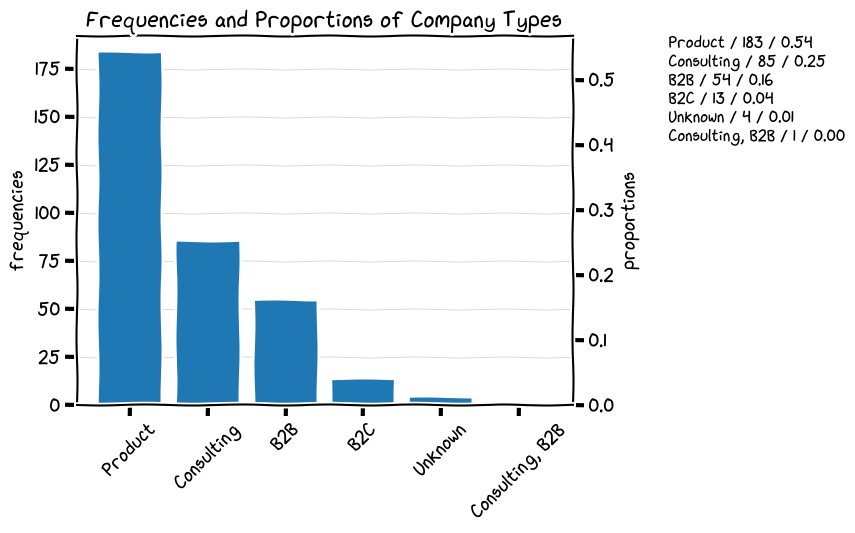

In [18]:
plot_freq_and_prop(type_vcounts, "Frequencies and Proportions of Company Types")

**Which remote work policies do these companies apply?**

In [19]:
policy_vcounts = companies_df.remote_policy.value_counts(dropna=False)

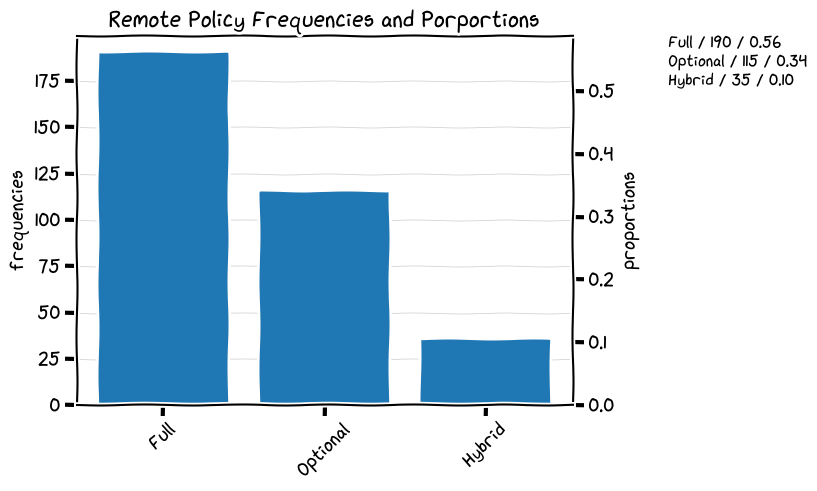

In [20]:
plot_freq_and_prop(policy_vcounts, "Remote Policy Frequencies and Porportions")

**Which technologies are used in these companies?**  
There is quite some enthropy in the "tags" column. Lots of technolgies have more than one tag because of formatting (i.e. "VMWare" vs "VMware") or even because of different styling (i.e. "Unity 3D" vs "Unity3D").  
Fist we need to put some order if we want to describe the data meaningfully.

In [21]:
# Some of the values might not even be lists
for taglist in companies_df.tags:
    if type(taglist) != list:
        print(taglist, end=" ")

nan nan nan nan nan nan nan 

In [22]:
# fixing nan values
num_of_na_values = companies_df.tags.isna().sum()
companies_df.loc[companies_df.tags.isna(), "tags"] = [["unknown"]]*num_of_na_values

There is also quite a number of companies in which the absence of tags is represented as a list containing only the "-" string. Let's replace that too.

In [23]:
# replacing ["-"] with ["unknown"]
num_of_dash_tags = companies_df.loc[:, ["tags"]].map(lambda tl: tl==["-"]).tags.sum()
companies_df.loc[companies_df.loc[:, ["tags"]].map(lambda tl: tl==["-"]).tags, "tags"] = [["unknown"]]*num_of_dash_tags

How many unique tags do we have at this point?

In [24]:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 461 unique tags.


Now for the styling problems it would be ideal to build a mapping (an hash map, dict or whatever) between different versions of the same tag and a single version that we want to keep in our final dataset.  
461 tags are not that many tags to go through by hands to build our dictionary, but being that we are in 2024 this might just be the perfect job to delegate to an LLM chatbot.  
I fed the full list of unique tags to a famous LLM chatbot and after fiddling a bit with prompts to convince it to give me the desired output and finally came up with a dict that looks like this:

In [25]:
from tags_repl import tags_replacement

In [26]:
for k in list(tags_replacement.keys())[4:11]:
    print(f"{k} -> {tags_replacement[k]}")

AI -> AI/ML
AI/ML -> AI/ML
API Integrations -> API Integrations
AR (Augmented Reality) -> AR (Augmented Reality)
ASP.NET Core -> ASP.NET Core
AWS -> AWS
AWS Cloud -> AWS


It is not completely perfect but most inconsistencies and duplicates are solved. Just a fast test to be sure nothing is missing...

In [27]:
print("Any tags coming from hallucinations?")
for t in tags_replacement.keys():
    if t not in unique_tags:
        print(t)

Any tags coming from hallucinations?


In [28]:
print("Any tags disappeared in the process?")
keys_repl = set(tags_replacement.keys())
for t in unique_tags:
    if t not in keys_repl:
        print(t)

Any tags disappeared in the process?


... and looks like we are good to go.

In [29]:
def replace_tags(tl: list[str]):
    return [tags_replacement[t] for t in tl]

companies_df.tags = companies_df.loc[:, "tags"].map(replace_tags)

We have 369 unique tags.


There is still a minor annoyance: some tags are "composite" like "JavaScript/TypeScript" or "Node.js/React". In some cases they make sense but other times we want to split them.

In [45]:
tags_to_split = [
    "Java/Maven", "Elixir/Erlang", "JavaScript/TypeScript", "Node.js/React", "C#/.NET"
]
def split_composite_tags(tl: list[str]):
    new_tl = []
    for t in tl:
        if t in tags_to_split:
            new_tl.extend(t.split("/"))
        else:
            new_tl.append(t)
    return new_tl

companies_df.tags = companies_df.tags.map(split_composite_tags)

In [49]:
# update the unique tags list:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 367 unique tags.


Let's try to visualize **the most requested technolgies and skills** from companies hiring Italian developers remotely.

In [51]:
tag_counts = {}
for t in unique_tags:
    tag_counts[t] = companies_df.tags.map(lambda tl: t in tl).sum()

In [52]:
tags_counts_df = pd.DataFrame.from_dict(tag_counts, orient="index", columns=["count"])

In [75]:
tags_counts_df.sort_values(by="count", ascending=False, inplace=True)

In [105]:
tags_counts_df.insert(
    loc=len(tags_counts_df.columns),
    column="proportion",
    value=tags_counts_df.loc[:, "count"]/len(companies_df)
)

In [54]:
from wordcloud import WordCloud

(-0.5, 899.5, 899.5, -0.5)

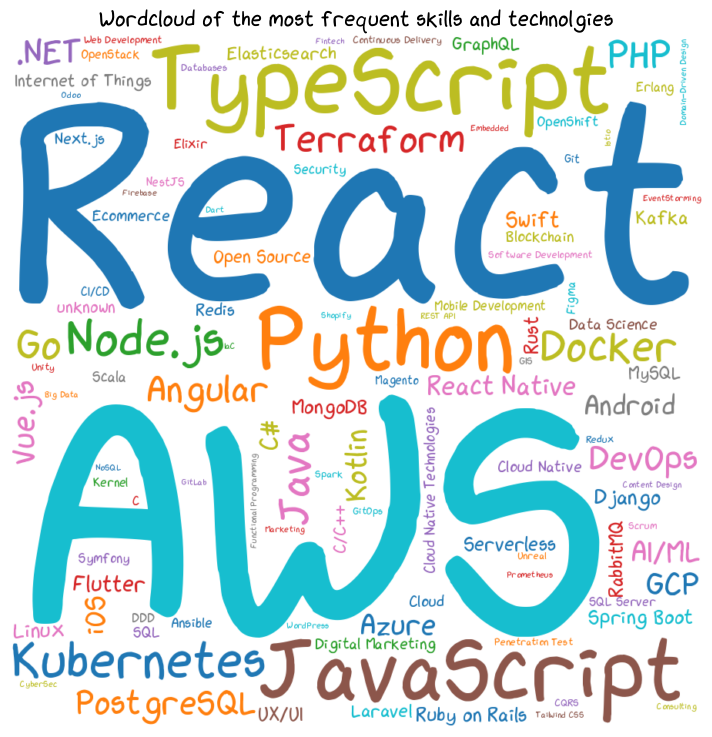

In [78]:
height = 900
width = 900
my_dpi = 96
wc = WordCloud(width=width, height=height, min_font_size=12, background_color="white", colormap="tab10", font_path="xkcd-script.ttf", max_words=500
).generate_from_frequencies(tag_counts)
plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation="bilinear")
plt.title("Wordcloud of the most frequent skills and technolgies")
plt.axis("off")

In [106]:

tags_counts_df

,count,proportion
AWS,151,0.444118
React,140,0.411765
TypeScript,120,0.352941
Python,110,0.323529
JavaScript,101,0.297059
...,...,...
REST,1,0.002941
Vulkan,1,0.002941
HR,1,0.002941
SPID,1,0.002941


Text(0.5, 1.0, "Top 25 tech/skills appearing in companies' tags")

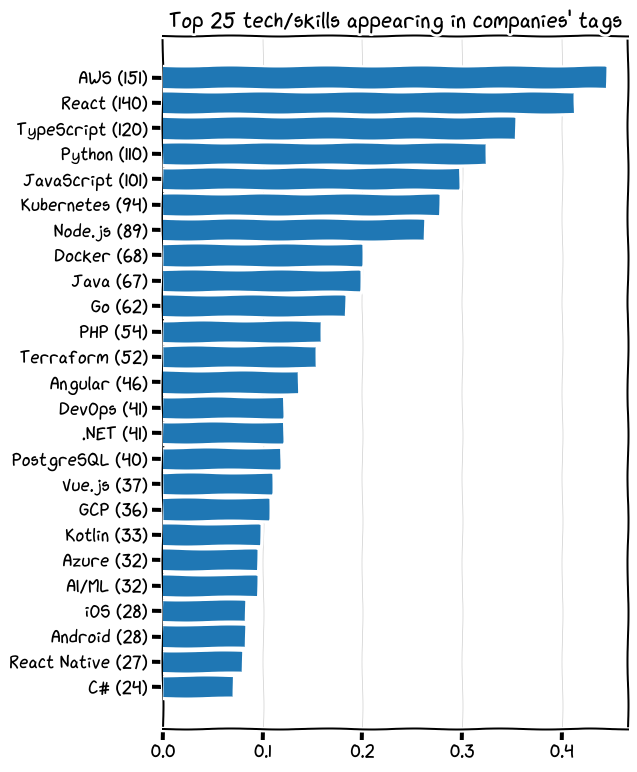

In [151]:
temp_df = tags_counts_df.sort_values(by="proportion").tail(25)
plt.figure(figsize=(600/my_dpi, 900/my_dpi), dpi=my_dpi)
y_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
plt.barh(width=temp_df.loc[:, "proportion"], y=y_labels, zorder=3)
plt.grid(visible=True, axis="x", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Top 25 tech/skills appearing in companies' tags")

Text(0.5, 1.0, "Bottom 25 tech/skills appearing in companies' tags")

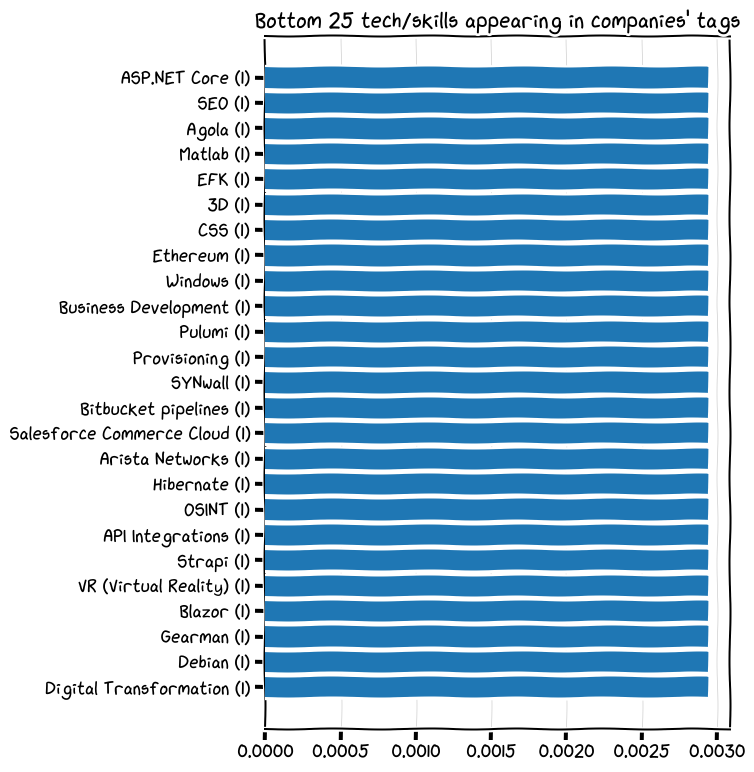

In [152]:
temp_df = tags_counts_df.sort_values(by="proportion", ascending=False).tail(25)
plt.figure(figsize=(600/my_dpi, 900/my_dpi), dpi=my_dpi)
y_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
plt.barh(width=temp_df.loc[:, "proportion"], y=y_labels, zorder=3)
plt.grid(visible=True, axis="x", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Bottom 25 tech/skills appearing in companies' tags")